In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import xlens
import glob

In [31]:
def get_ngal_in_healpix(catalog, ra_name="ra", dec_name="dec"):
    # set the nside
    nside = 1024
    npix = hp.nside2npix(nside)
    
    # initialize a count map
    ngal = np.zeros(npix, dtype=int)
    
    # ra, dec of your galaxy catalog (in degrees)
    # these should be arrays of equal length
    ra = catalog[ra_name]        # shape (n,)
    dec = catalog[dec_name]      # shape (n,)
    
    # convert to theta (colatitude) and phi (longitude) in radians
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)
    
    # convert to healpix pixel indices (in nested ordering)
    pix = hp.ang2pix(nside, theta, phi, nest=True)
    
    # Count galaxies per pixel
    np.add.at(ngal, pix, 1)
    return ngal

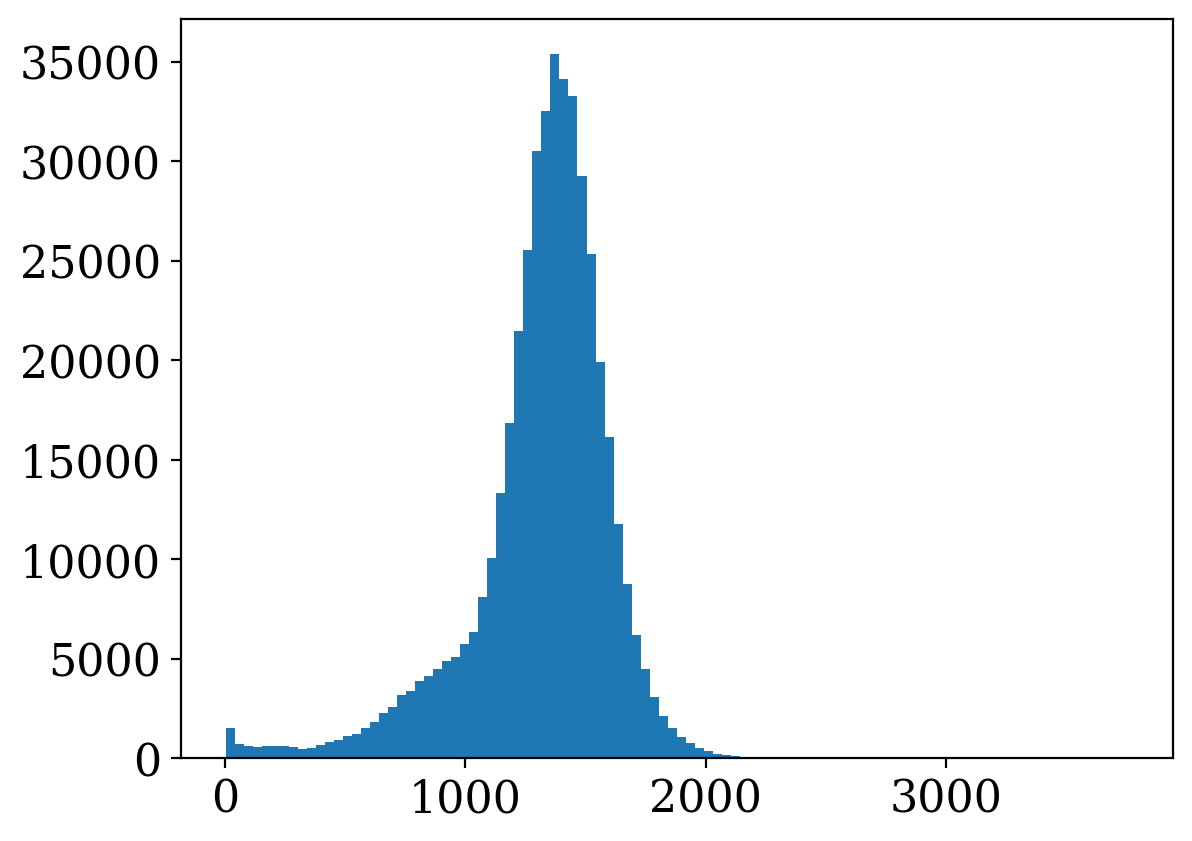

In [33]:
if False:
    NSIDE = 1024
    base_dir = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_color/"
    
    fnames = glob.glob(base_dir+"/*.fits")
    npix = hp.nside2npix(NSIDE)
    ngals = np.zeros(npix, dtype=int)
    for fname in fnames:
        data = fitsio.read(fname, columns=["i_ra", "i_dec"])
        ngals = ngals + get_ngal_in_healpix(data, ra_name="i_ra", dec_name="i_dec")
    _ = plt.hist(ngals[ngals>3], bins=100)
    hpfname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window_premask.fits"
    mask = (ngals>2)
    hp.write_map(
        hpfname, 
        mask.astype(np.bool_),
        dtype=np.bool_, nest=True, 
        overwrite=True,
    )

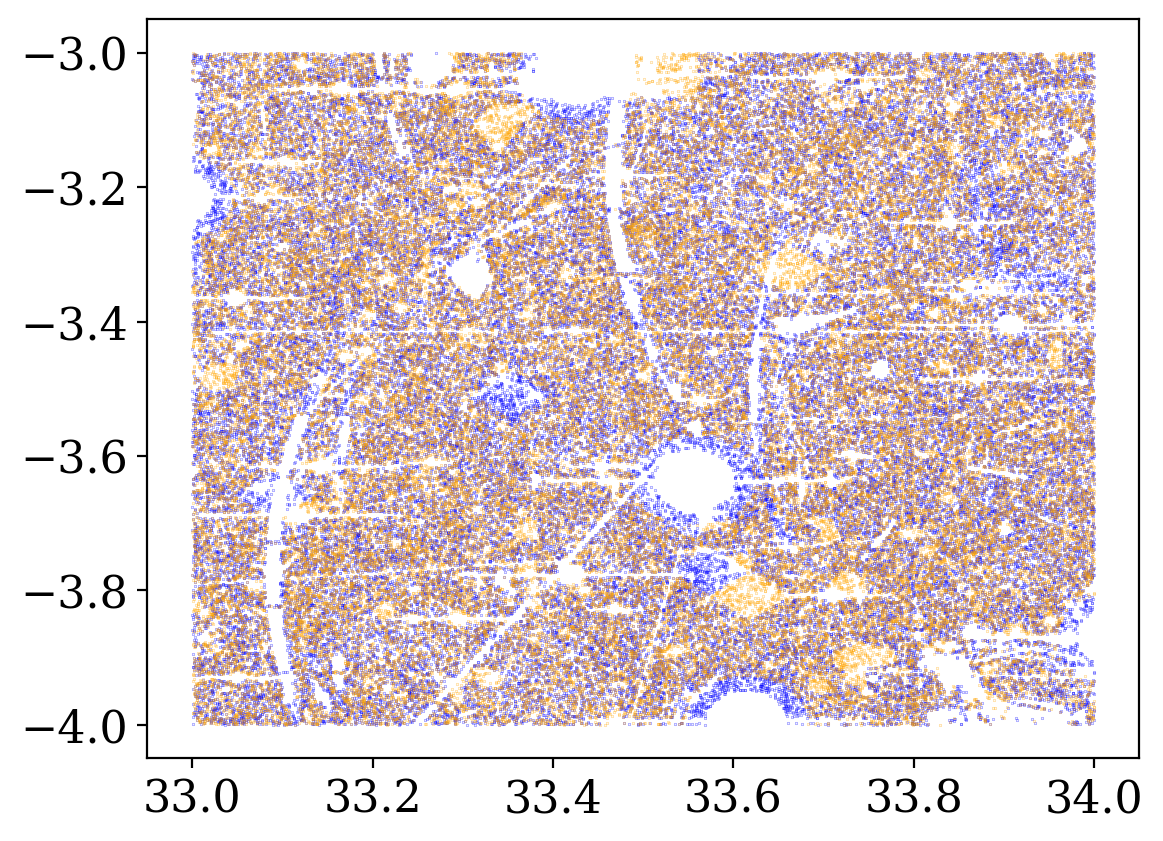

In [7]:
fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/autumn2.fits"
data = fitsio.read(fname)
data = data[data["i_flux_gauss4"] < 24.5]
data = data[(data["ra"]>33.0) & (data["ra"]<34.0) & (data["dec"]> -4.0) & (data["dec"]< -3.0)]
fname = f"/gpfs02/work/xiangchong.li/work/S19ACatalogs/catalog_obs_reGaus_public/XMM.fits"
data2 = fitsio.read(fname)
data2 = data2[(data2["i_ra"]>33.0) & (data2["i_ra"]<34.0) & (data2["i_dec"]>-4.0) & (data2["i_dec"]<-3.0)]
plt.scatter(data["ra"], data["dec"], s=0.01, color="blue")
plt.scatter(data2["i_ra"], data2["i_dec"], s=0.01, color="orange")

In [35]:
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
npix = hp.nside2npix(NSIDE)
ngals = np.zeros(npix, dtype=int)
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/{field}.fits"
    data = fitsio.read(fname)
    ngals = ngals + get_ngal_in_healpix(data)

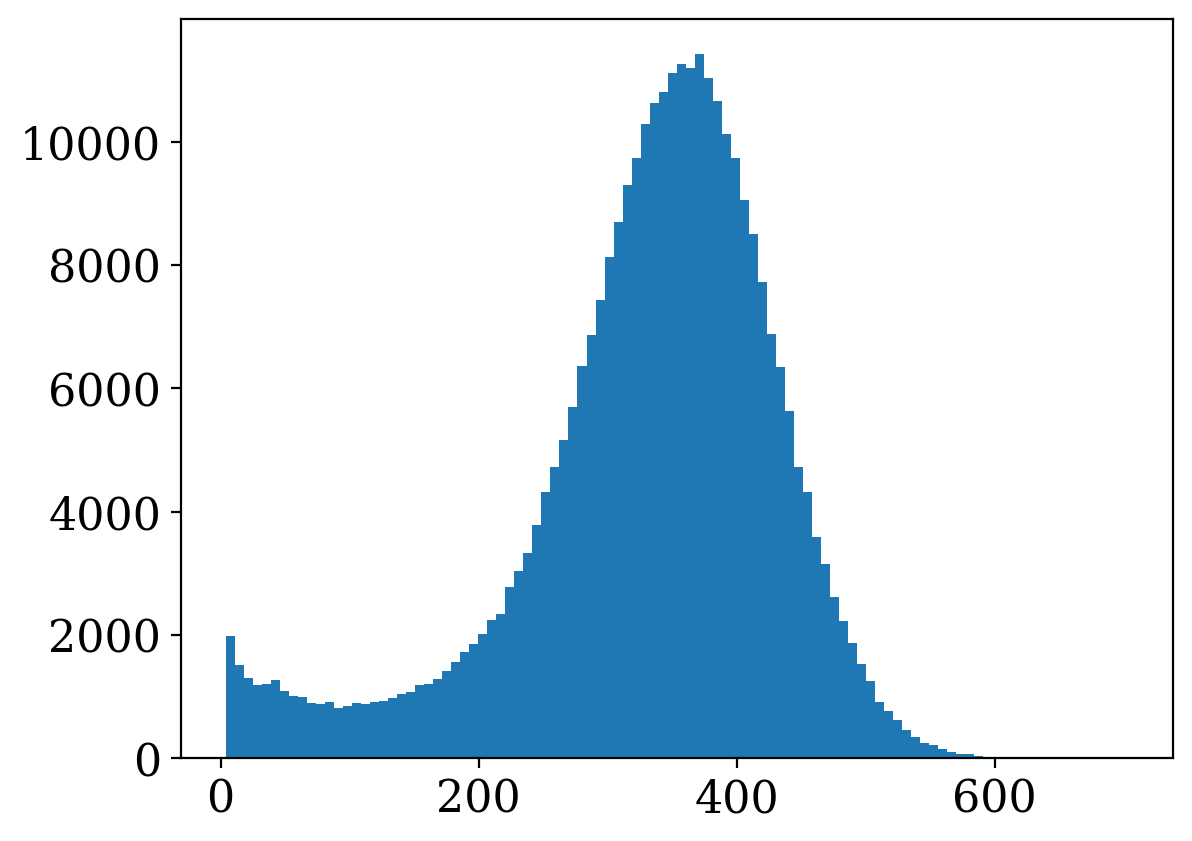

In [7]:
_ = plt.hist(ngals[ngals>3], bins=100)

In [10]:
hpfname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window_v2.fits"
mask = (ngals>3)
hp.write_map(
    hpfname, 
    mask.astype(np.bool_),
    dtype=np.bool_, nest=True, 
    overwrite=True,
)

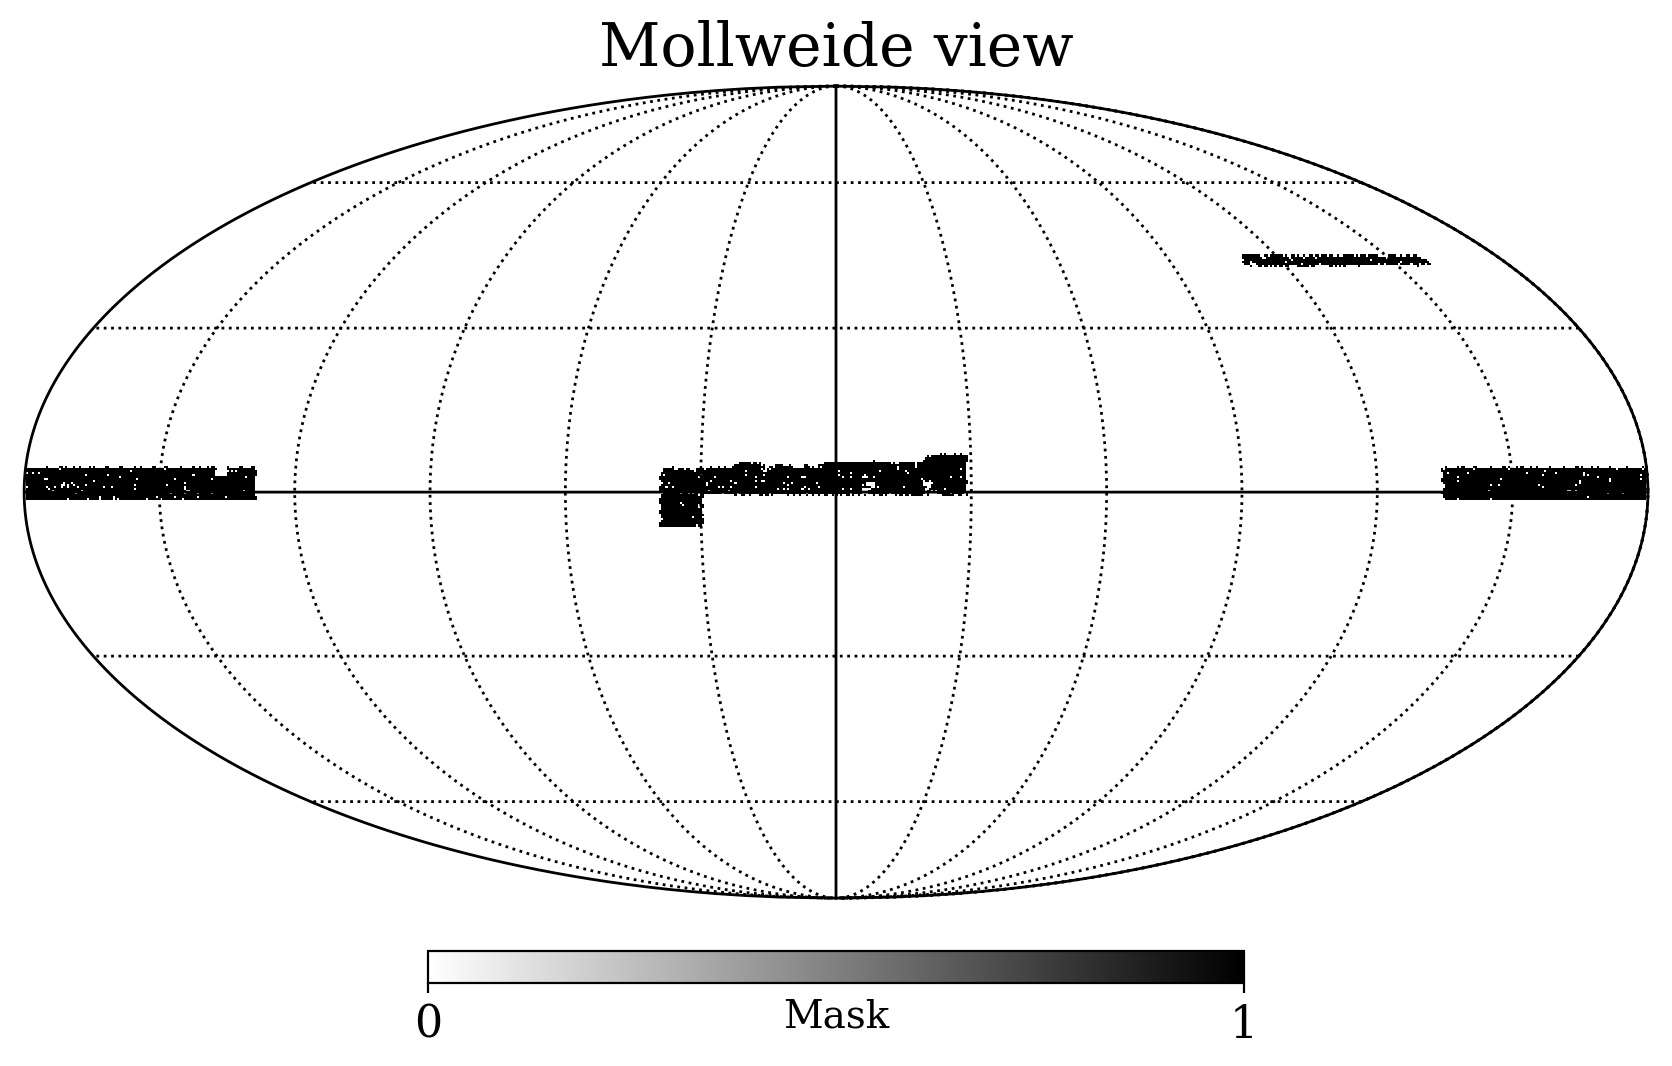

In [3]:
hpfname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window_v2.fits"
mask = hp.read_map(hpfname, nest=True, dtype=bool)
hp.mollview(mask.astype(float), nest=True, cmap="gray_r", unit="Mask")
hp.graticule()
plt.show()

In [6]:
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/{field}.fits"
    data = pyfits.getdata(fname)
    
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields_color/{field}.fits"
    data2 = pyfits.getdata(fname)
    print(field)
    print(np.sum(np.abs(data["object_id"] - data2["object_id"])))
    del data, data2

spring1
0
spring2
0
spring3
0
autumn1
0
autumn2
0
hectomap
0


In [12]:
if False:
    NSIDE = 1024
    field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
    for field in field_list:
        fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
        data = pyfits.getdata(fname)
        ra = data['i_ra']        
        dec = data['i_dec']     
        
        theta = np.deg2rad(90.0 - dec)
        phi = np.deg2rad(ra)
        
        # Convert to HEALPix pixel indices (in NESTED ordering)
        pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
        mm = mask[pix]
        data = data[mm]
        print(np.sum(mm) / len(mm))
        pyfits.writeto(fname, data, overwrite=True)
        del data

0.9940237693393307
0.9955035150416098
0.9955717160878379
0.9938660713399154
0.9945501759878842
0.9955437729179639


In [89]:
if False:
    NSIDE = 1024
    field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
    for field in field_list:
        fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_star/fields/{field}.fits"
        data = pyfits.getdata(fname)
        data["i_higherordermomentspsf_13"] = -data["i_higherordermomentspsf_13"]
        data["i_higherordermomentspsf_31"] = -data["i_higherordermomentspsf_31"]
        data["i_higherordermomentssource_13"] = -data["i_higherordermomentssource_13"]
        data["i_higherordermomentssource_31"] = -data["i_higherordermomentssource_31"]
        pyfits.writeto(fname, data, overwrite=True)

In [2]:
up1 = 0
up2 = 0
down1 = 0
down2 = 0
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/{field}.fits"
    data = fitsio.read(fname, columns=["g_flux_gauss4", "r_flux_gauss4", "i_flux_gauss4", "z_flux_gauss4", "y_flux_gauss4", "e1", "e2", "de1_dg1", "de2_dg2", "wsel", "dwsel_dg1", "dwsel_dg2"])
    mag = 27.0 - 2.5 * np.log10(data["i_flux_gauss4"])
    g = 27.0 - 2.5 * np.log10(data["g_flux_gauss4"])
    r = 27.0 - 2.5 * np.log10(data["r_flux_gauss4"])
    i = 27.0 - 2.5 * np.log10(data["i_flux_gauss4"])
    z = 27.0 - 2.5 * np.log10(data["z_flux_gauss4"])
    y = 27.0 - 2.5 * np.log10(data["y_flux_gauss4"])
    abse2 = data["e1"] ** 2.0 + data["e2"] ** 2.0
    mask = (
        (mag < 25.0) &
        (abse2 < 0.09)
    )
    data = data[mask]
    up1 += np.sum(data["e1"] * data["wsel"])
    up2 += np.sum(data["e2"] * data["wsel"])
    down1 += np.sum(data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"])
    down2 += np.sum(data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"])
    print(np.sum(data["e1"] * data["wsel"]) / np.sum(data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"]))
    print(np.sum(data["e2"] * data["wsel"]) / np.sum(data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"]))
    del data, g, r, z, i, y, mask

/gpfs02/work/xiangchong.li/work/tmp/ipykernel_13466/3413910997.py:10: RuntimeWarning: invalid value encountered in log10
  g = 27.0 - 2.5 * np.log10(data["g_flux_gauss4"])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_13466/3413910997.py:11: RuntimeWarning: invalid value encountered in log10
  r = 27.0 - 2.5 * np.log10(data["r_flux_gauss4"])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_13466/3413910997.py:13: RuntimeWarning: invalid value encountered in log10
  z = 27.0 - 2.5 * np.log10(data["z_flux_gauss4"])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_13466/3413910997.py:14: RuntimeWarning: invalid value encountered in log10
  y = 27.0 - 2.5 * np.log10(data["y_flux_gauss4"])


-0.000756275805688311
0.00011223244858182914
0.000494540259654708
0.00026235497435396824
0.0004273891850581653
-0.00016656471107458828
-0.0005694745514752709
-0.000350977707237895
-0.0003218004737356985
-0.0003363515629786746
8.193183952048716e-05
0.00022637173907691897


In [3]:
up1 / down1

-0.0001179595059157216

In [4]:
up2 / down2

-8.381570640977393e-05

In [5]:
(down1 - down2) / down2 / 2.0

-0.004595545984850609